In [2]:
import time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import marvin
import pandas as pd
from PyAstronomy import pyasl

%matplotlib inline

[INFO]: No release version set. Setting default to DR15
[WARNING]: path /Users/hinleung/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/hinleung/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject (RuntimeWarning)
[WARNING]: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject (RuntimeWarning)


In [3]:
lines_air_df = pd.read_fwf('../skylines.txt')
lines_vac = pyasl.airtovac2(lines_air_df[lines_air_df['flux']>=30]['wavelength'])
print(lines_vac)

[5578.8954556  6302.05104962 6365.54219491 8346.90679765 8401.48404869
 8401.48404869 8829.53629684 8888.29629305 8922.08573476 9315.90131855
 9326.32113949 9378.54917978 9442.25973032 9479.49541313 9793.80124247
 9874.8545013  9917.49585452 9949.24175613 9959.32848922]


In [4]:
#lines_vac = np.array([5578.5486,4279.2039,6301.7423,6365.7595])
def mask_sky(wave, masksize=10):
    """ Masks strong night sky emission lines that are often not removed 
    properly in the data processing. From masksky.pro """

    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    return mask, np.array([lines-masksize, lines+masksize]).T

In [47]:
# get cubes
ID_plateifu = '8080-3704'
mycube = marvin.tools.Cube(ID_plateifu)   #DRP cube
mymodelcube = marvin.tools.ModelCube(ID_plateifu) #DAP cube
maps = marvin.tools.Maps(ID_plateifu)    #get the maps too
ha_qual = maps['emline_gflux_ha_6564']

[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)


In [35]:
print(mycube)
print(mymodelcube)

<Marvin Cube (plateifu='8080-3704', mode='local', data_origin='file')>
<Marvin ModelCube (plateifu='8080-3704', mode='remote', data_origin='api', bintype='HYB10', template='GAU-MILESHC')>


In [48]:
# download the cubes
if mycube.mode == 'remote':
    mycube.download()
if mymodelcube.mode == 'remote':
    mymodelcube.download()
if maps.mode == 'remote':
    mymodelcube.download()

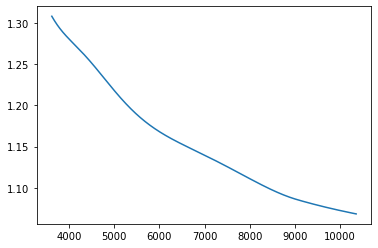

In [60]:
# Milky way attenuation
cube_redcorr = mymodelcube._redcorr
cube_redcorr_ = cube_redcorr[:,np.newaxis,np.newaxis]
plt.plot(mycube.flux.wavelength, cube_redcorr)

4563
4563


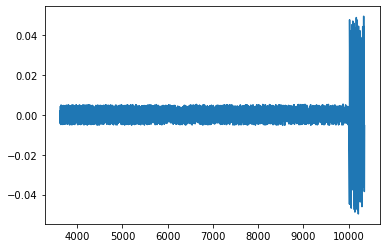

In [38]:
# wavelengths in the two cubes, though equal in length of array, are slightly different in values
print(len(mycube.flux.wavelength))
print(len(mymodelcube.binned_flux.wavelength))
plt.plot(mycube.flux.wavelength, mymodelcube.binned_flux.wavelength-mycube.flux.wavelength)

[WARNING]: divide by zero encountered in power (RuntimeWarning)


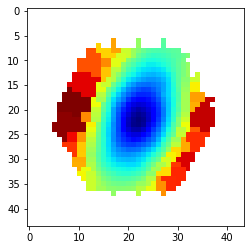

In [57]:
corrected_cube = mymodelcube.binned_flux.value * mymodelcube._redcorr[:,np.newaxis,np.newaxis]

idx = 2000
plt.imshow(corrected_cube[idx]**-0.5, norm=LogNorm(), cmap='jet')

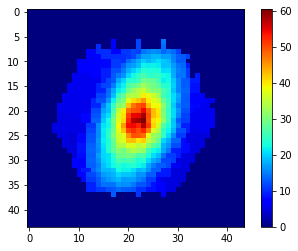

In [23]:
mean_SNR = np.mean(mymodelcube.binned_flux.snr,axis=0)
plt.imshow(mean_SNR, cmap='jet')
plt.colorbar()

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


inf


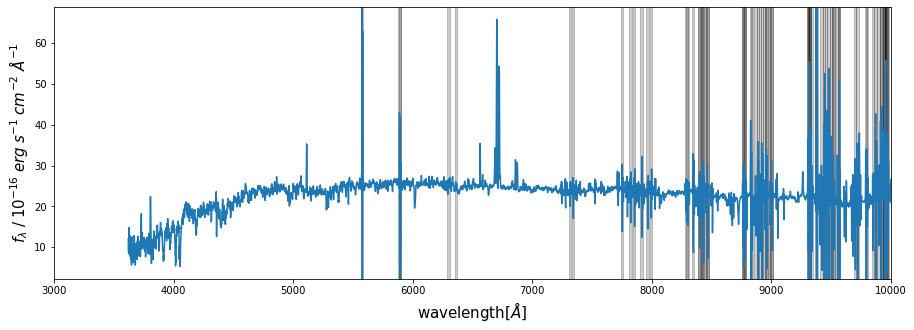

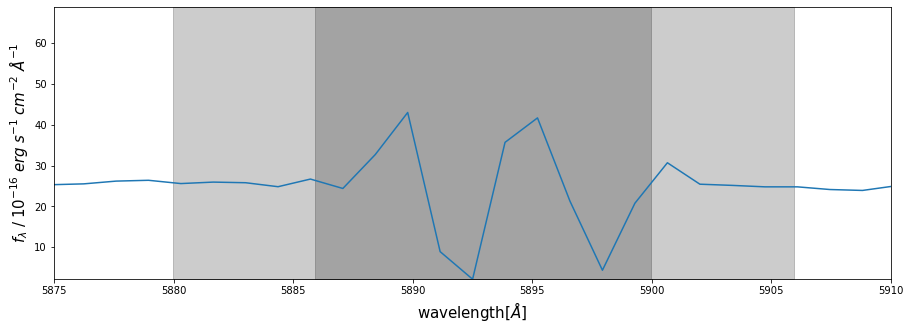

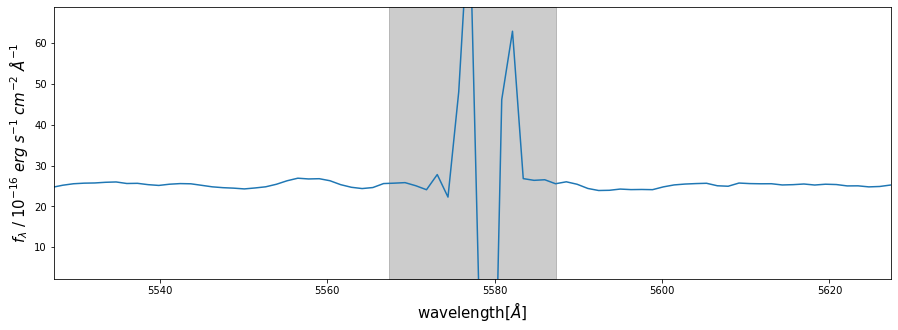

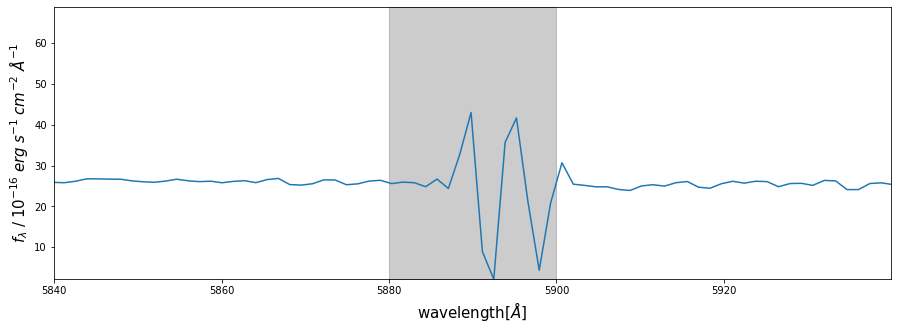

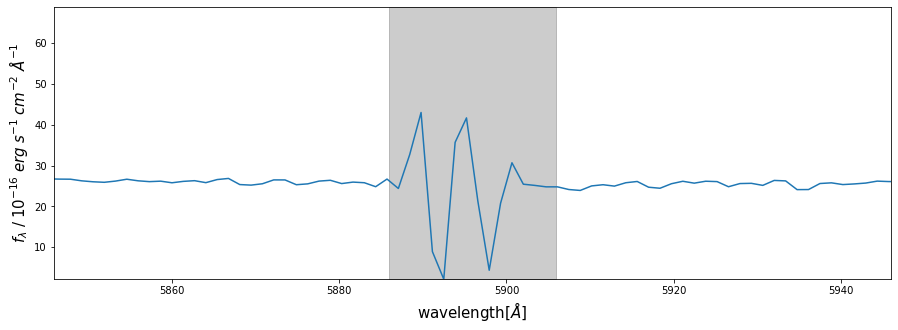

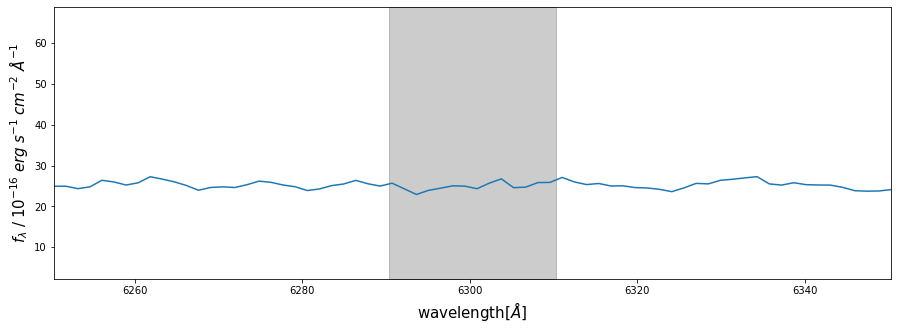

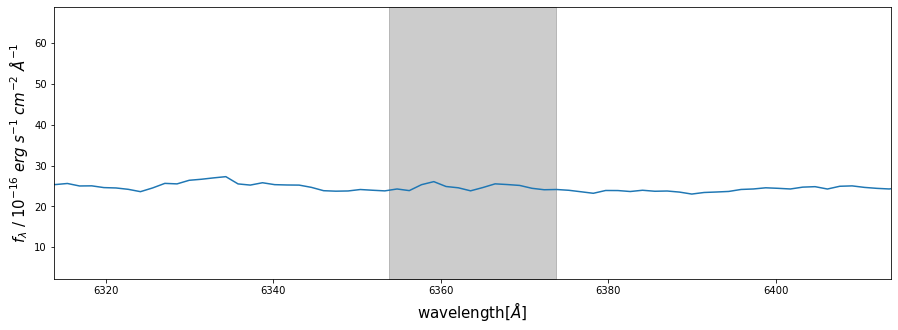

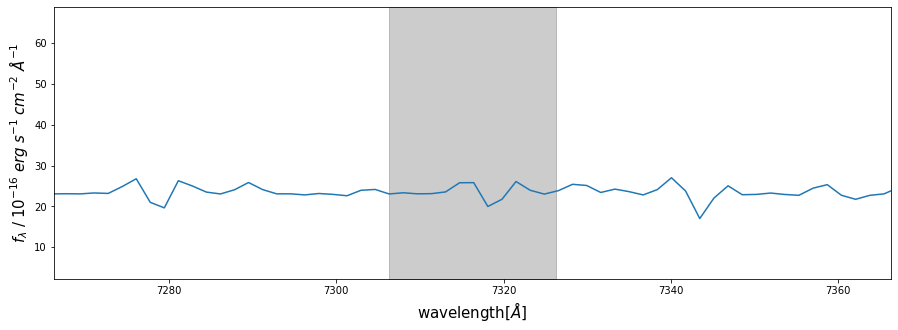

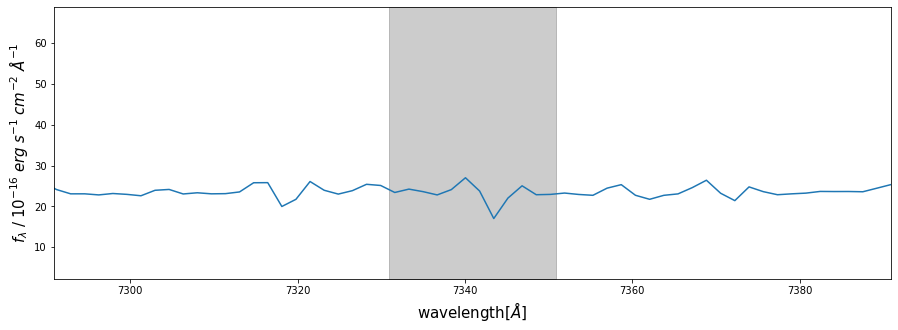

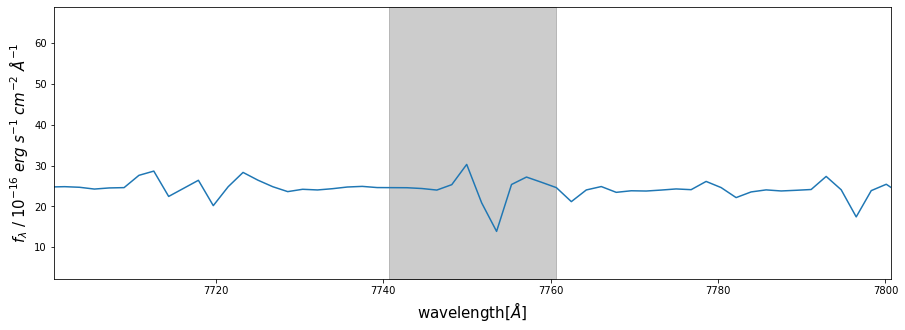

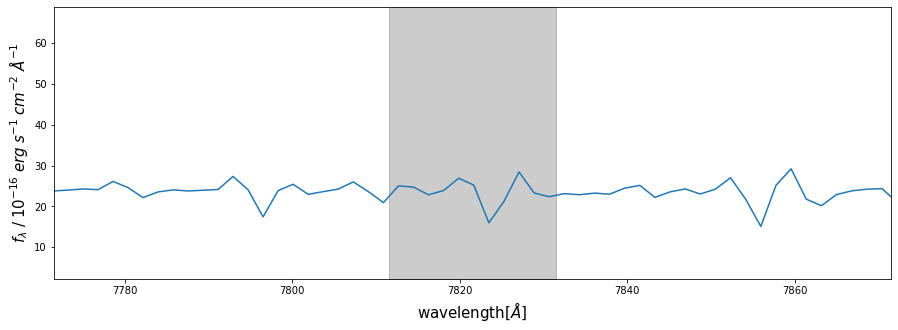

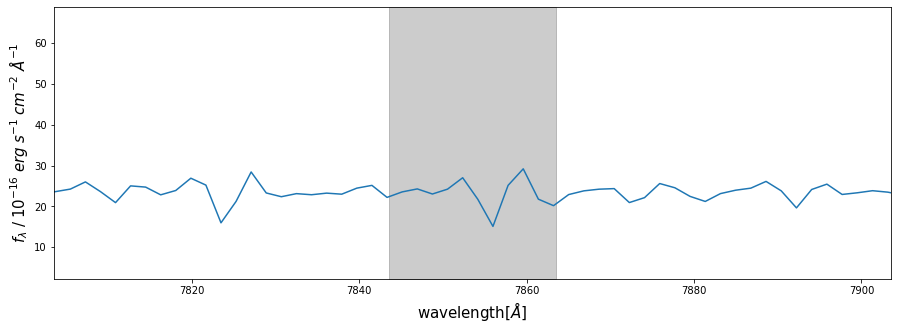

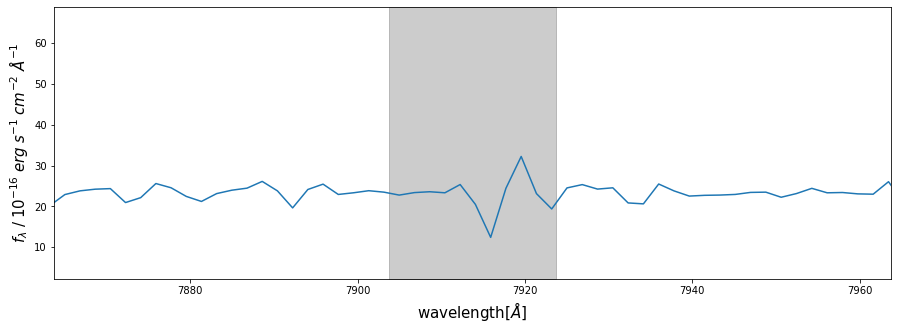

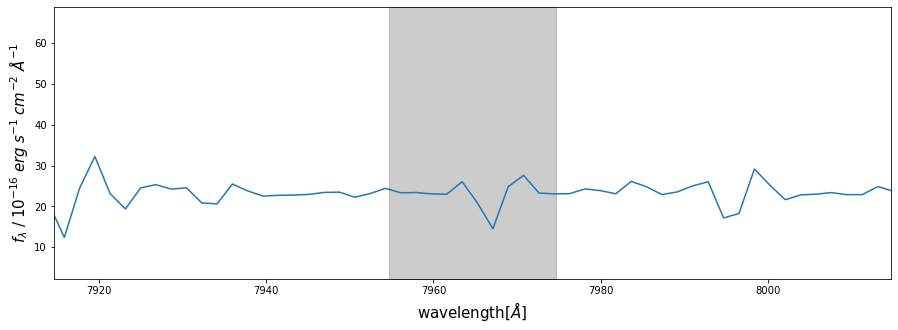

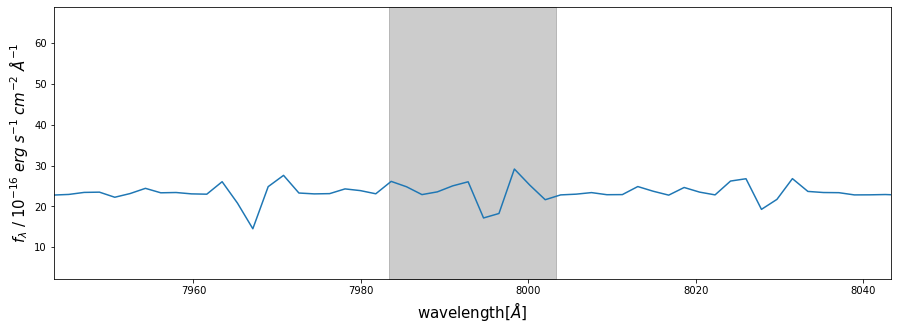

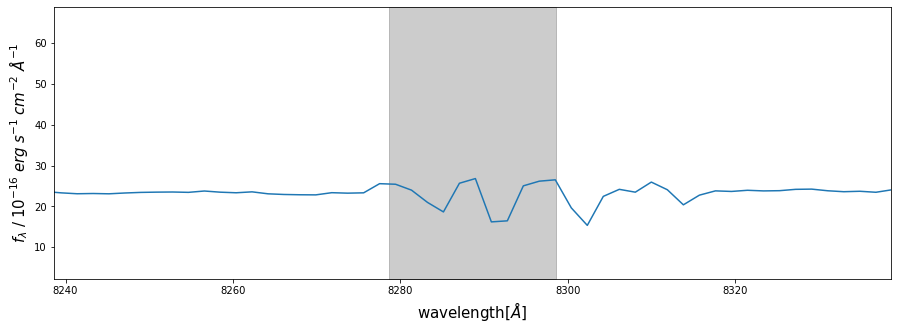

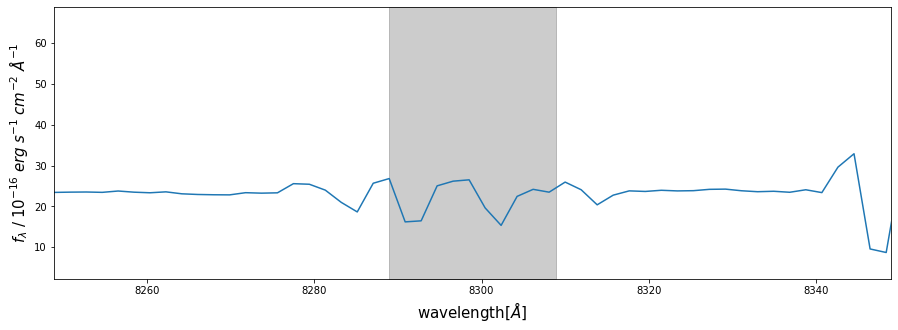

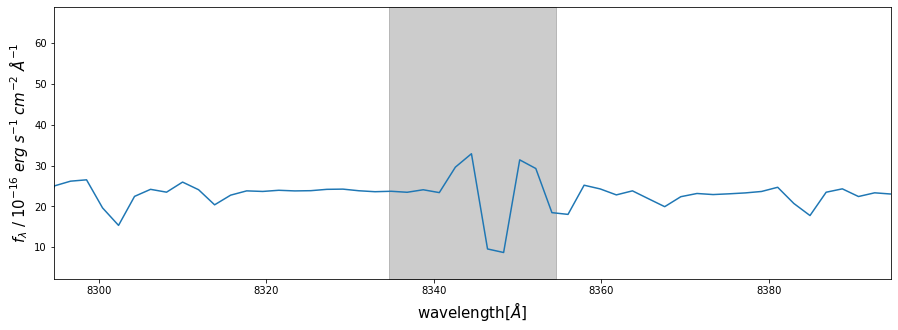

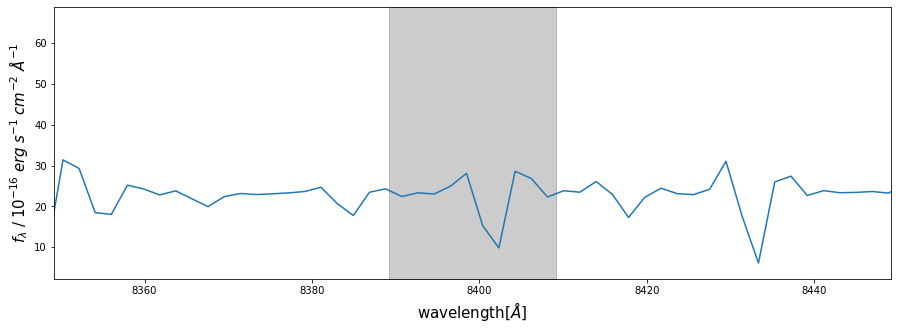

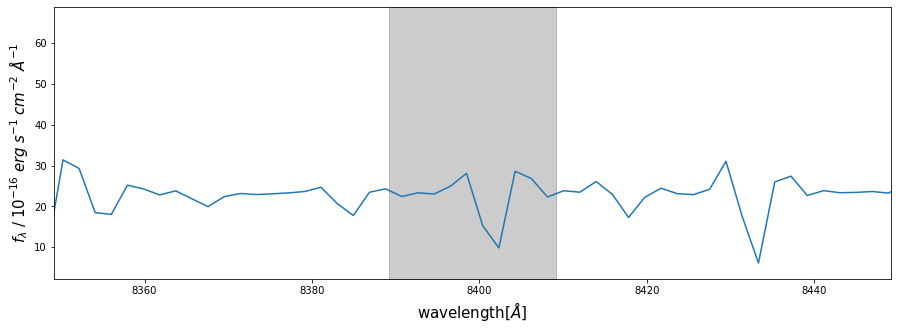

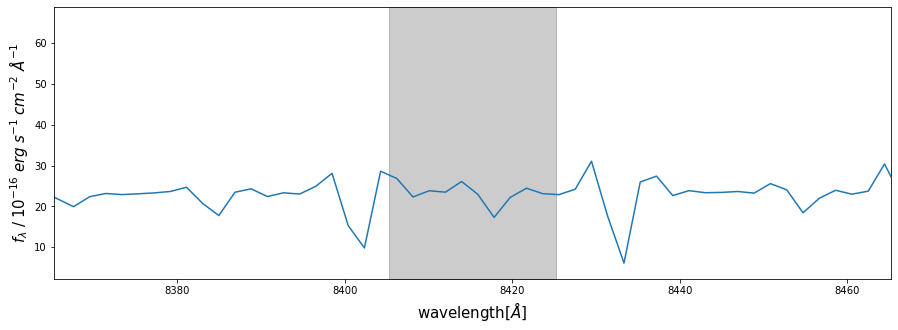

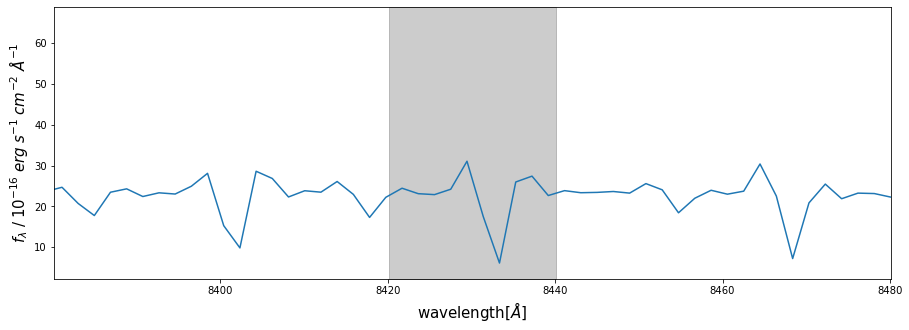

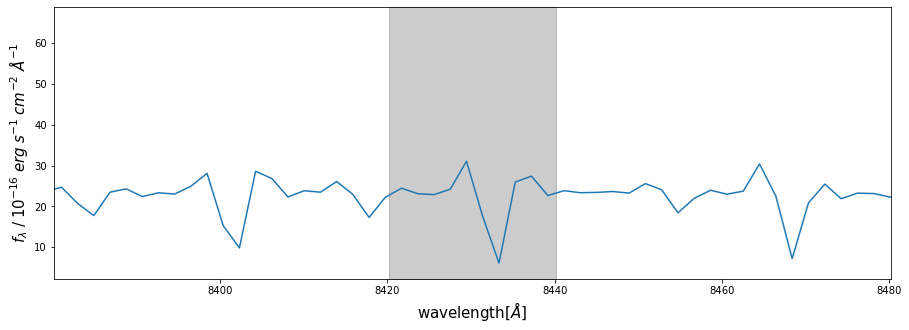

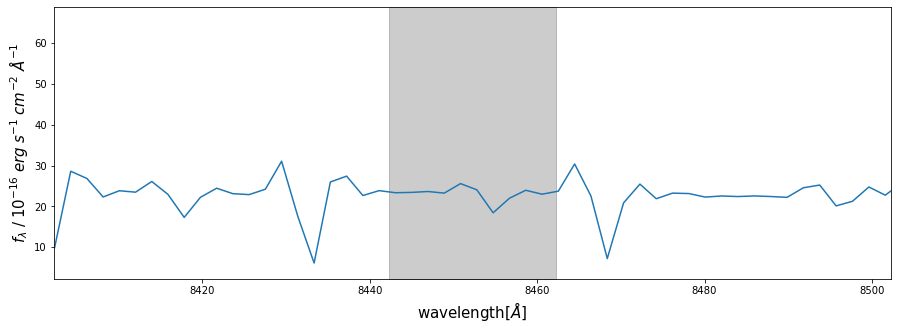

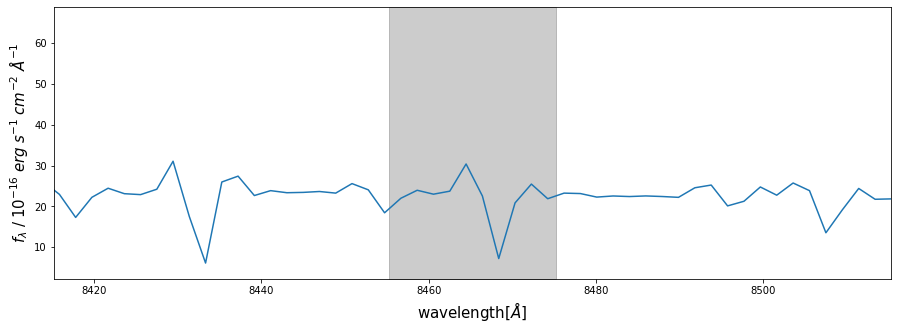

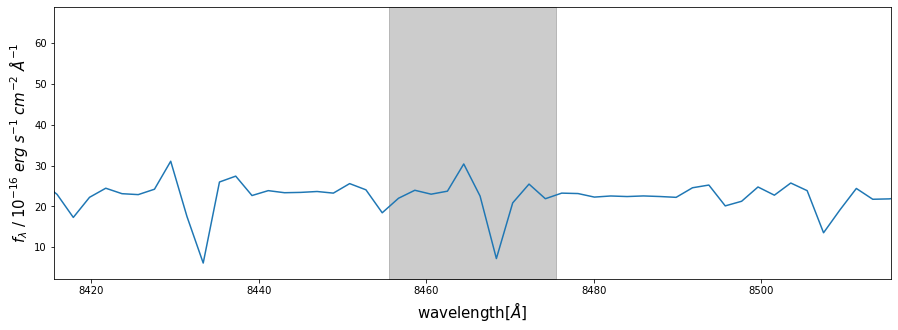

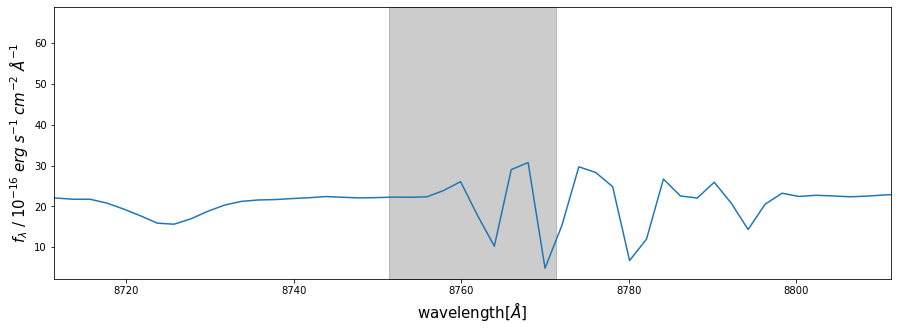

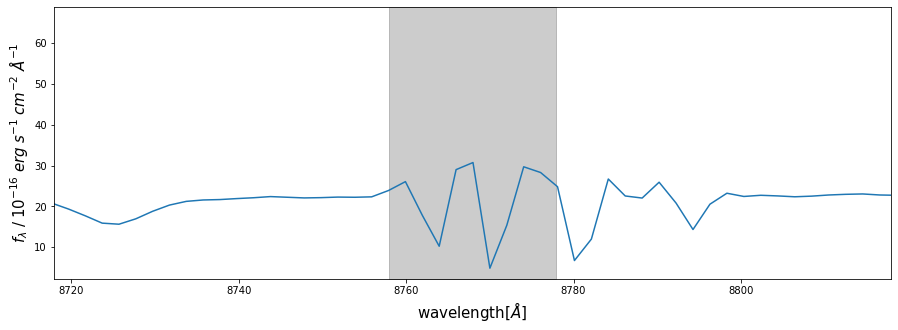

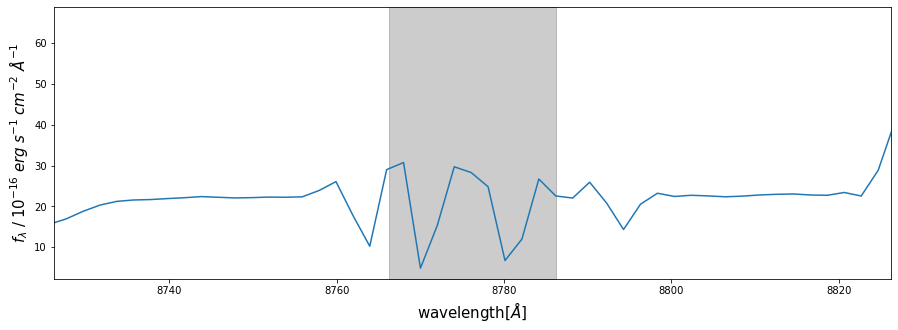

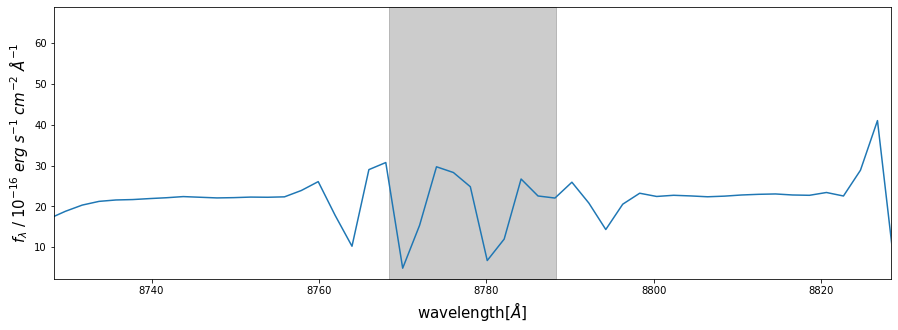

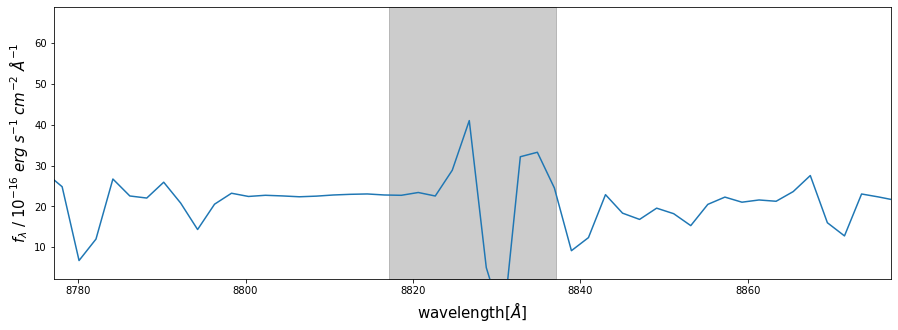

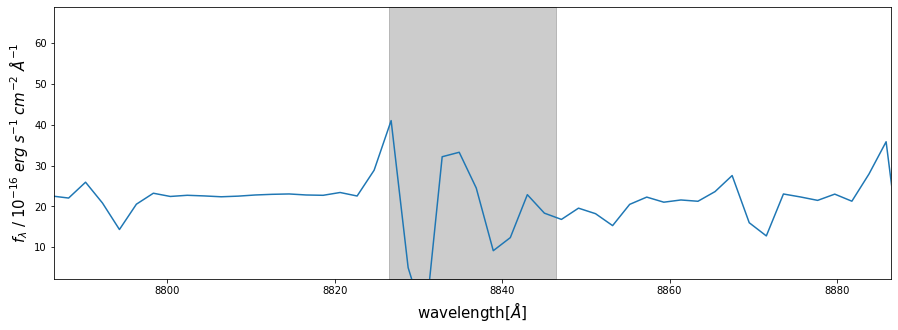

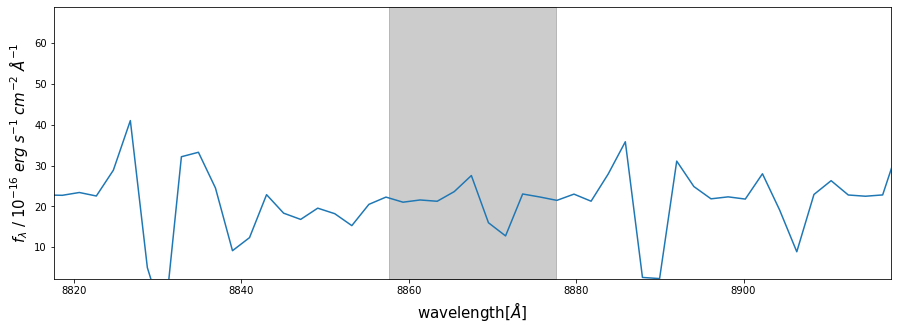

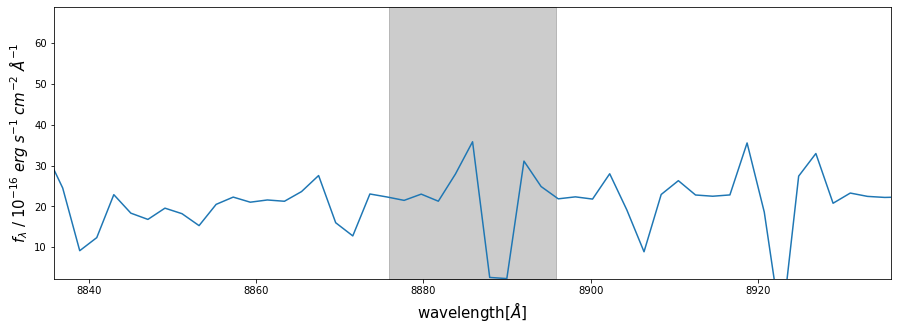

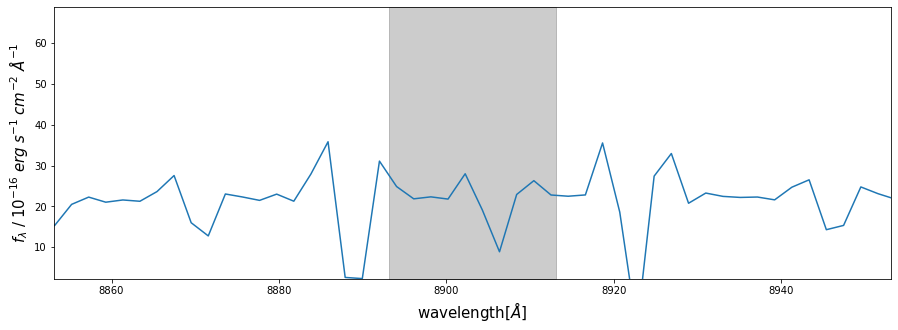

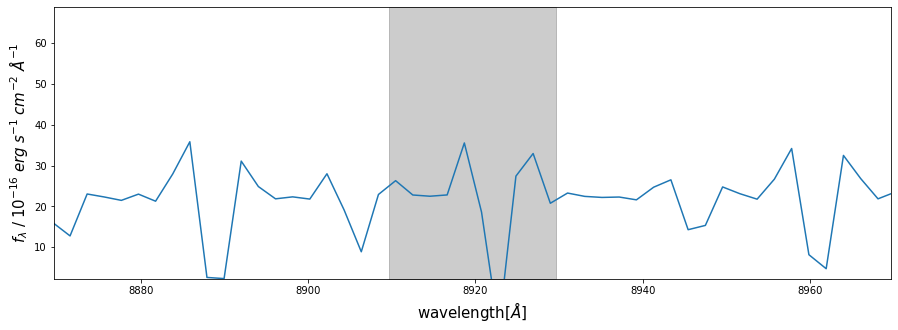

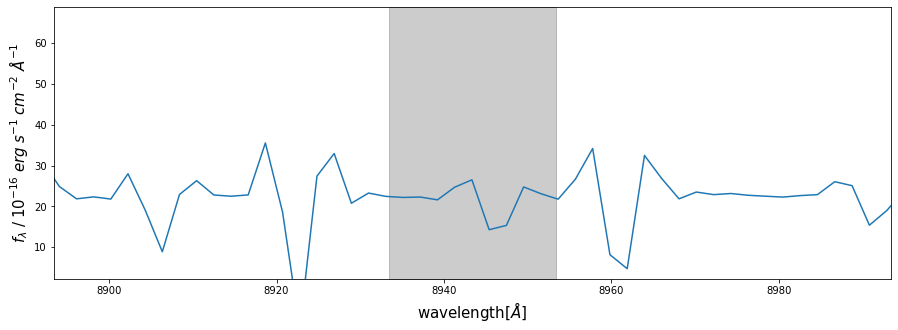

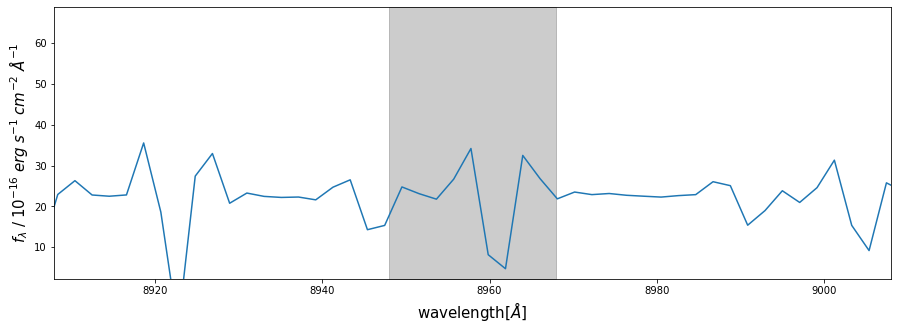

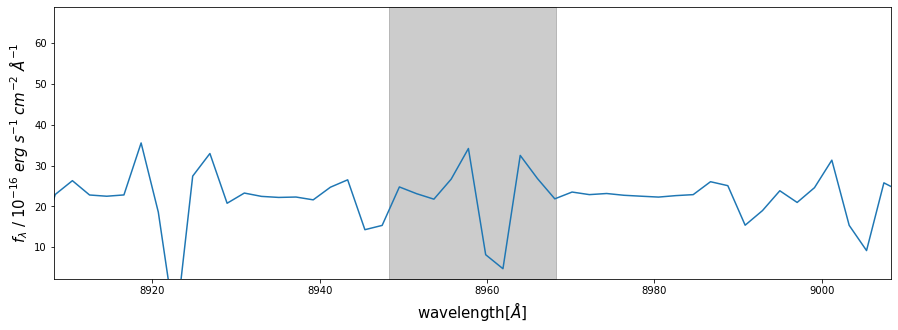

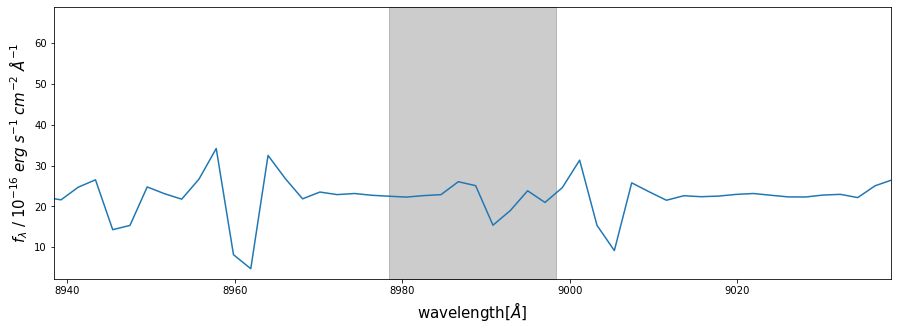

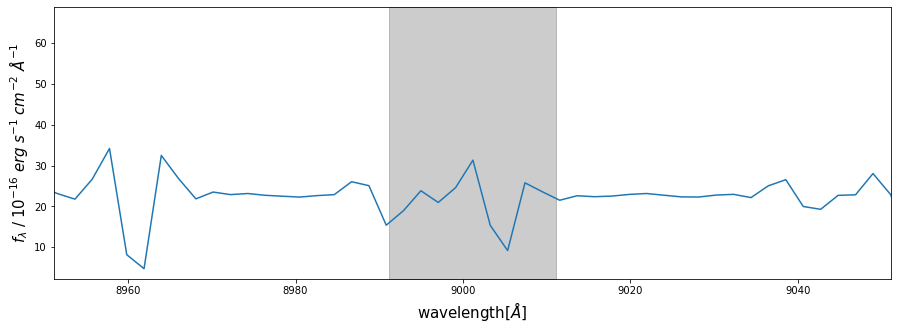

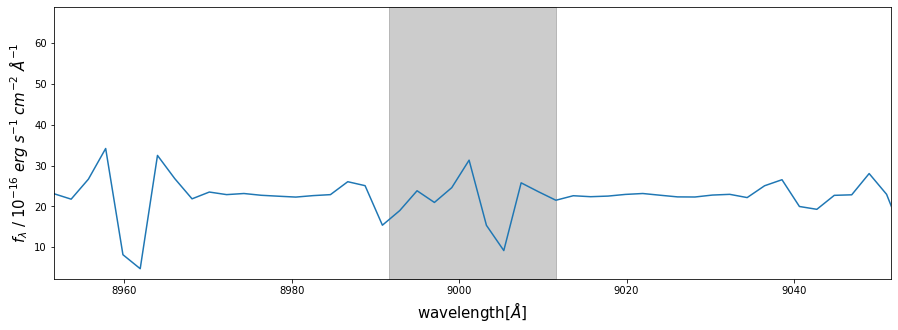

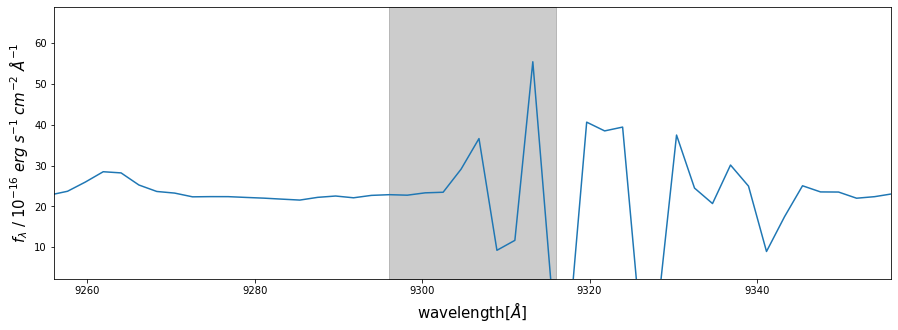

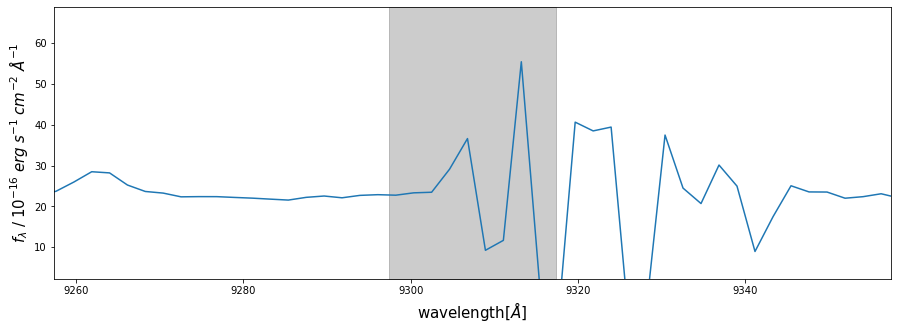

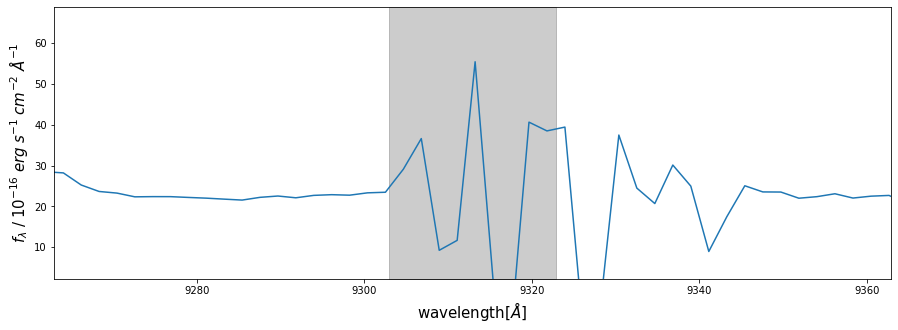

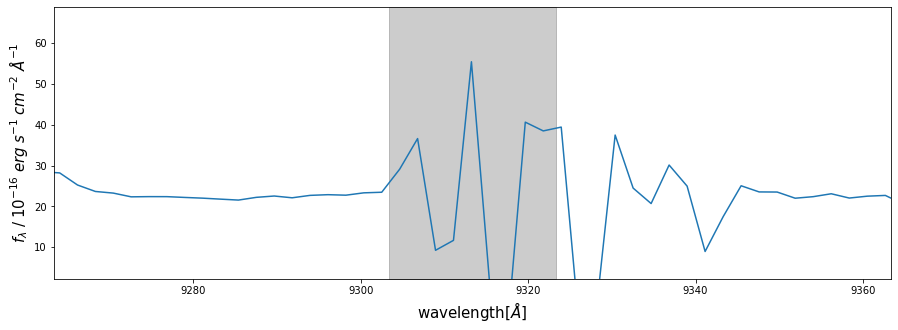

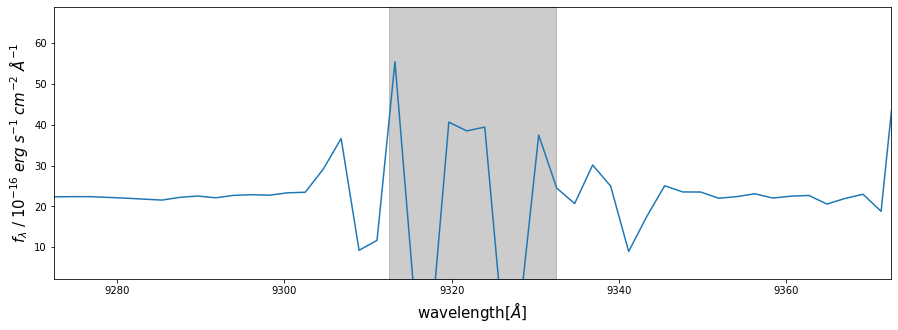

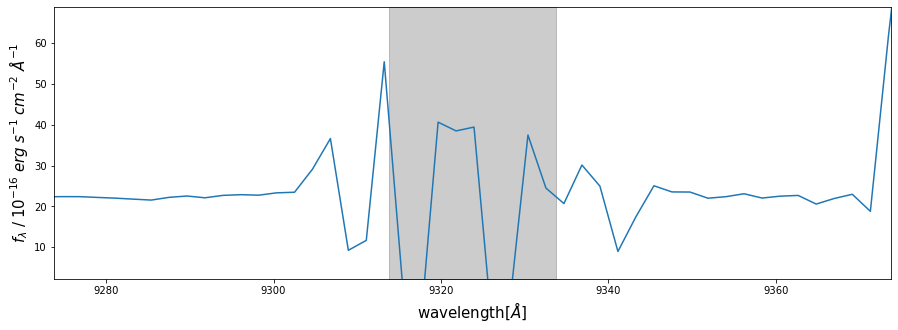

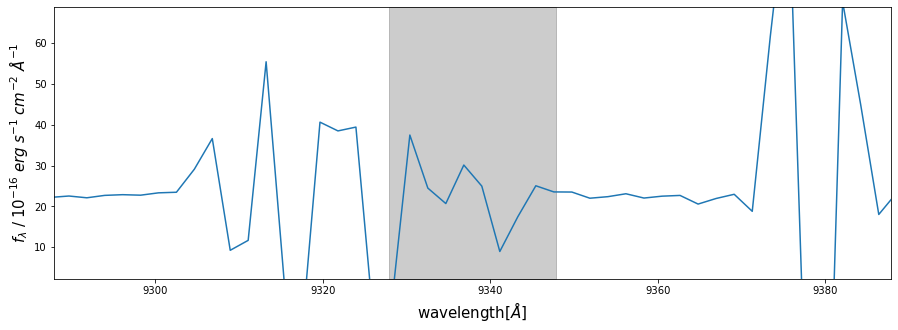

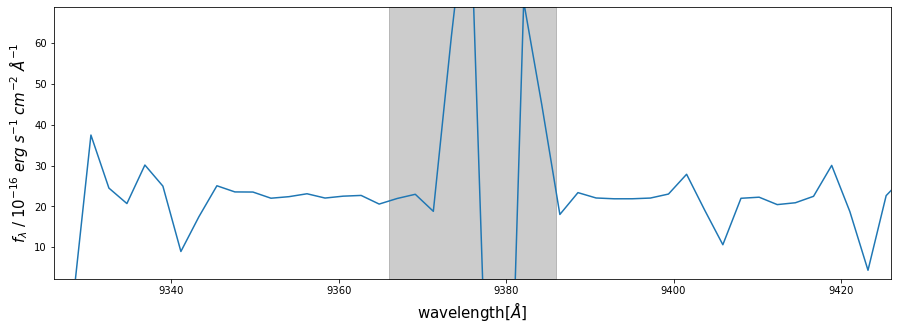

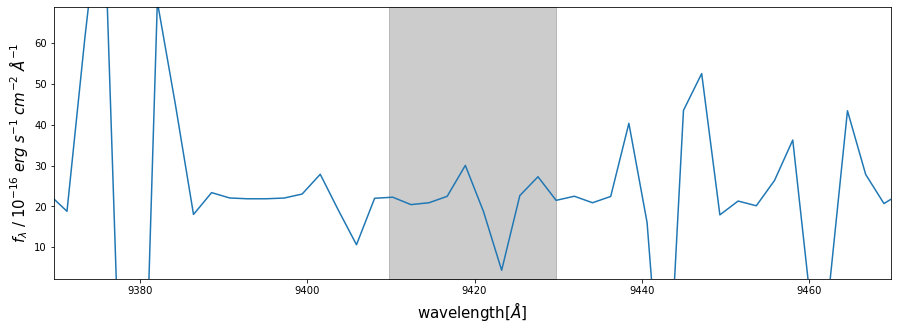

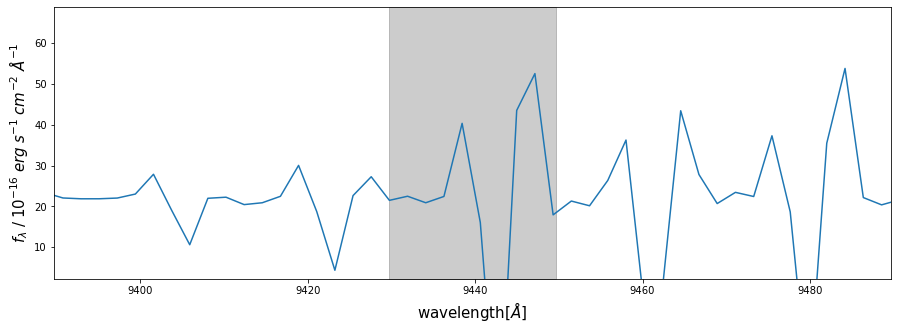

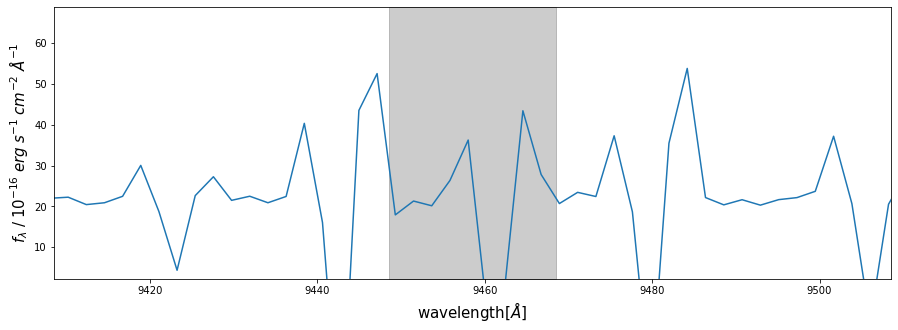

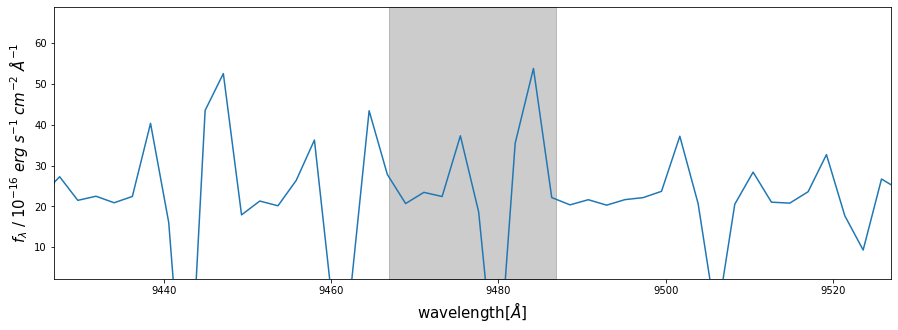

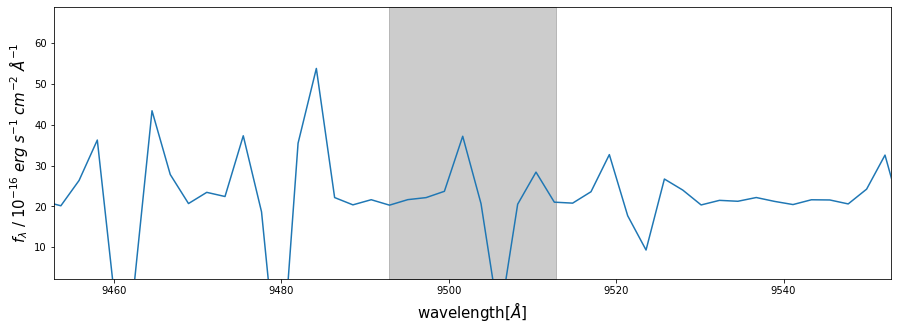

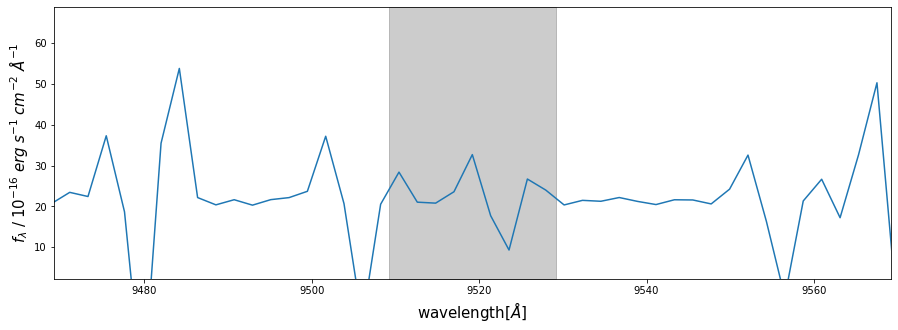

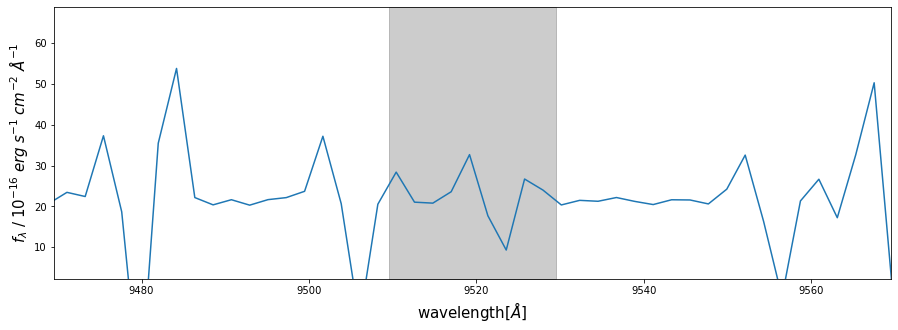

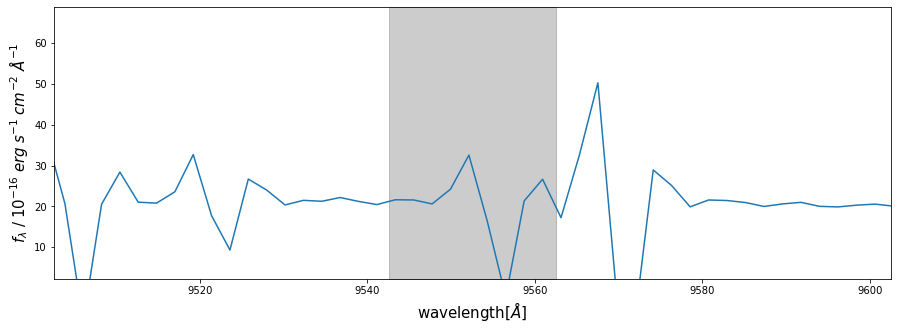

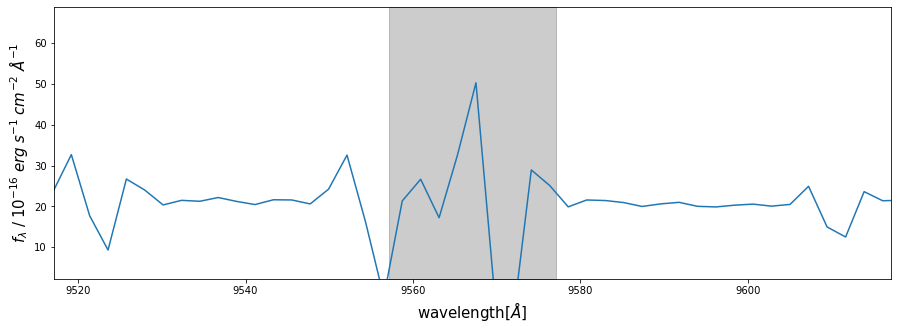

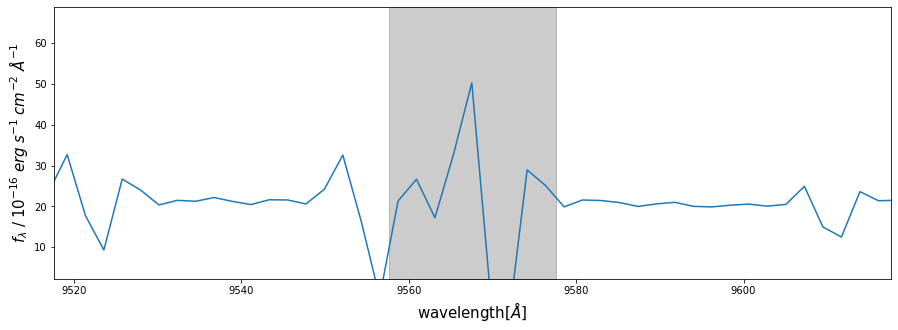

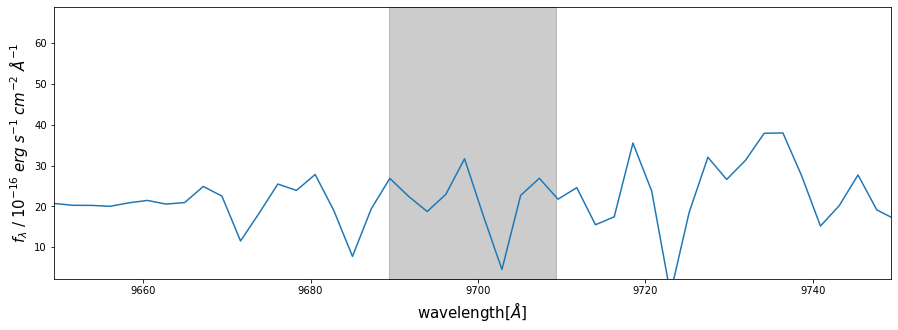

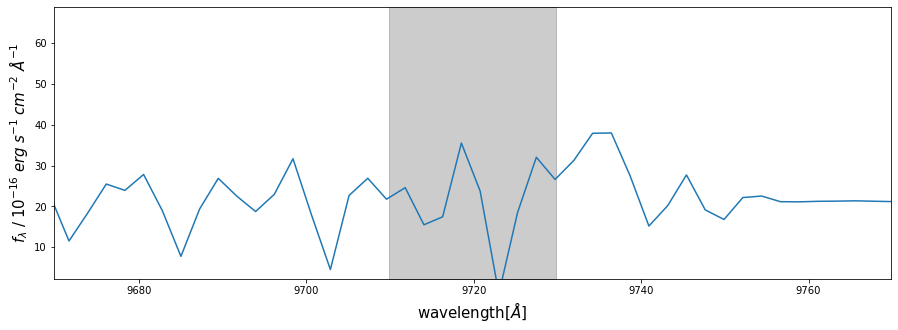

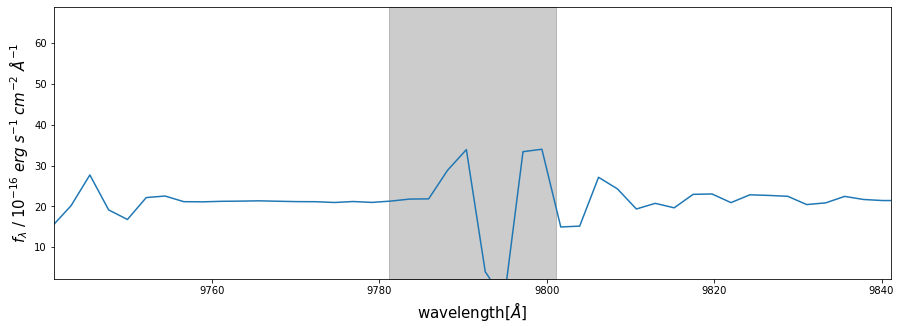

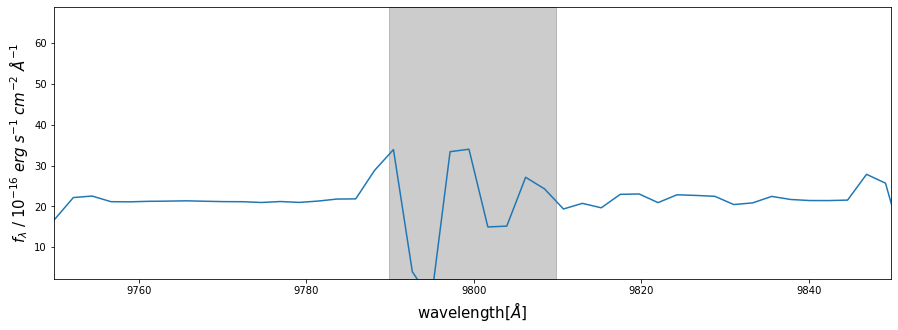

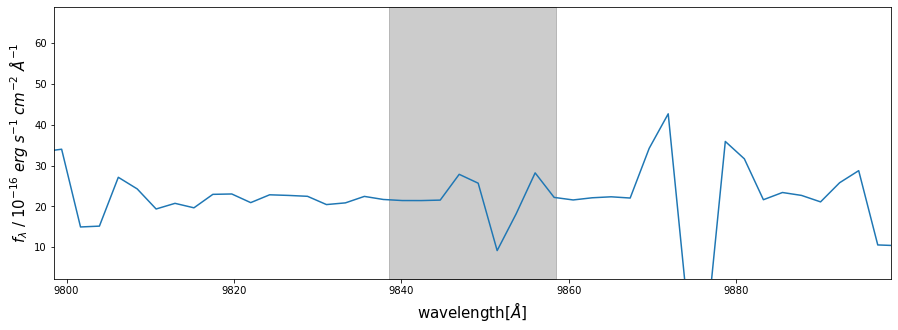

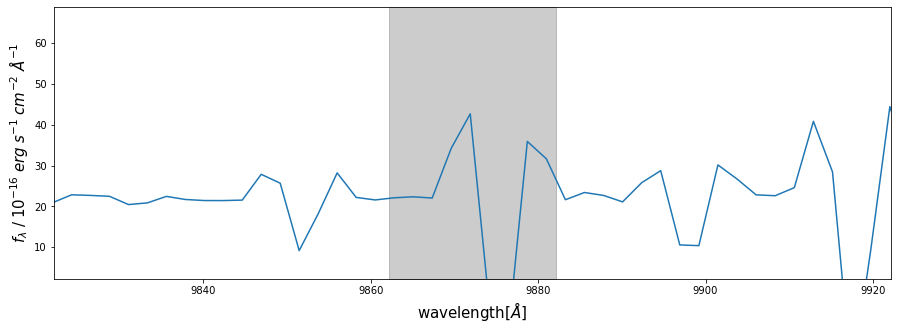

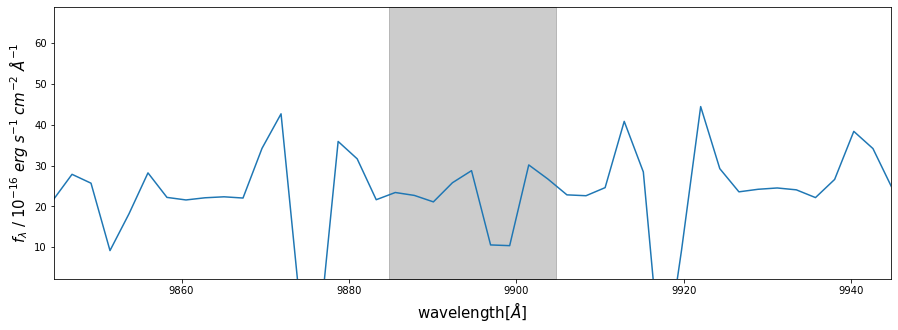

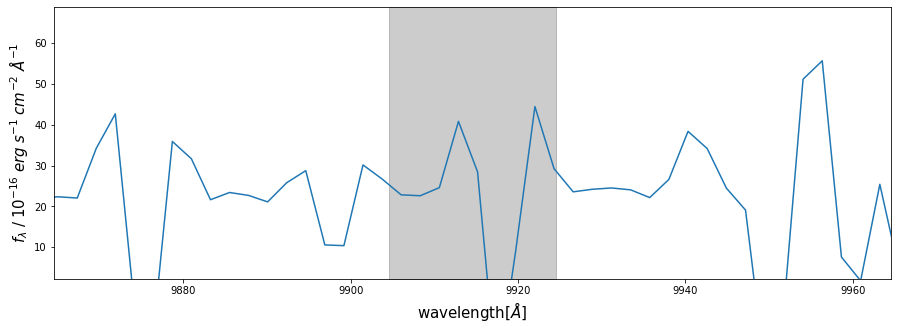

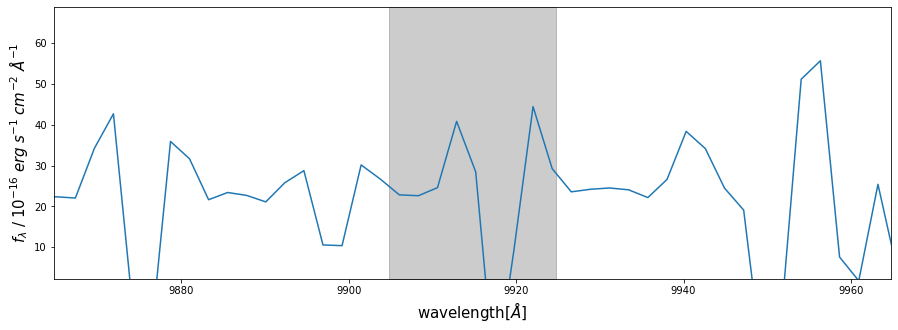

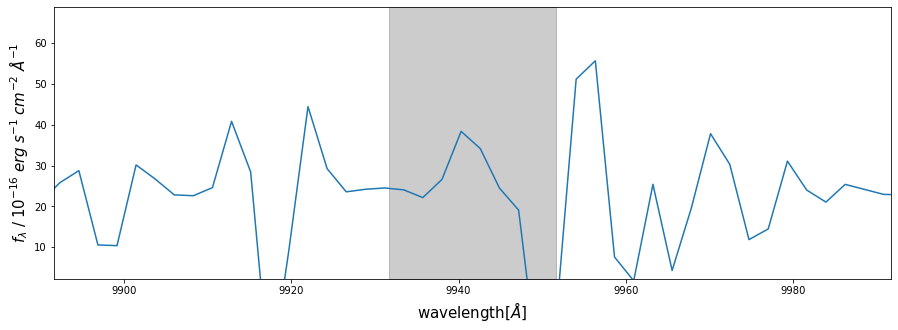

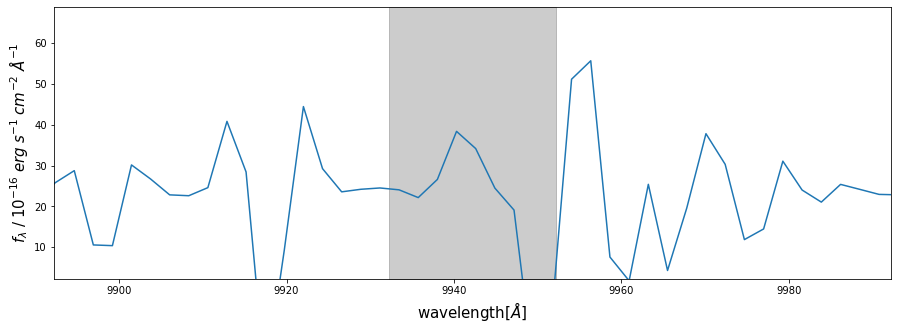

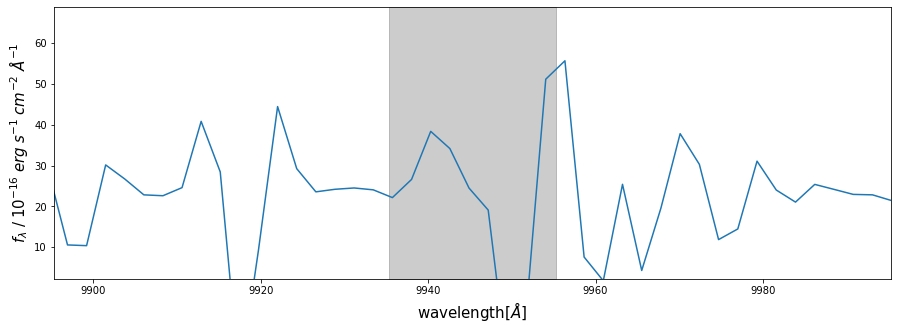

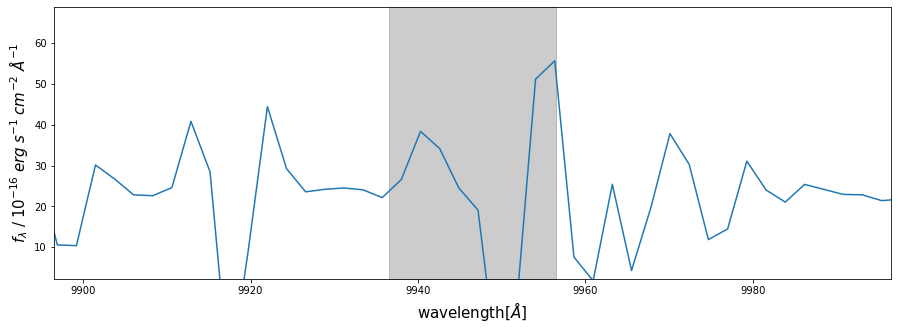

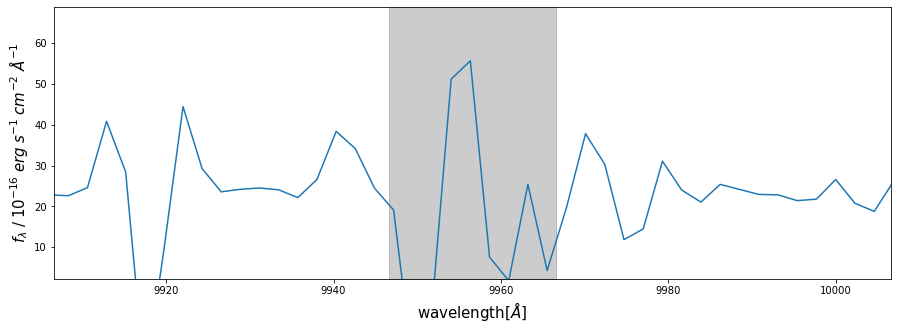

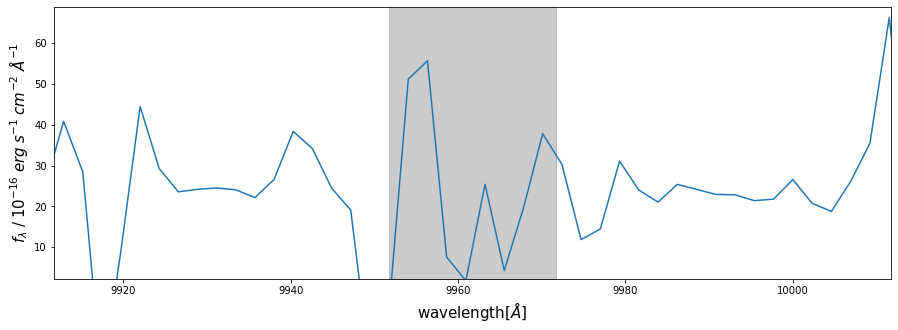

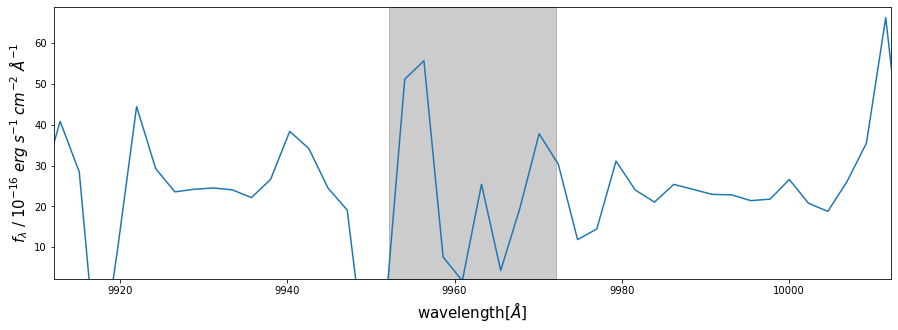

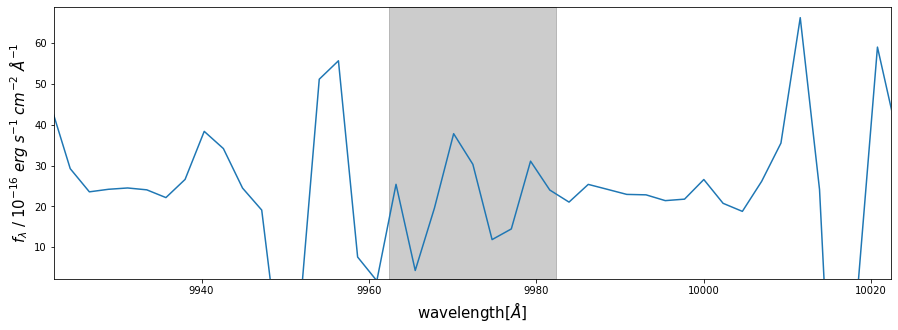

In [8]:
# summing all spaxels in the DRP cube together to create a full-galaxy SED

wavelength = mycube.flux.wavelength.value
spectrum = np.sum(mycube.flux.value, axis=(1,2))*10**-17
spec_mask, mask_lims = mask_sky(wavelength)
spec_masked = np.delete(spectrum, spec_mask)
ylims = np.array([min(spec_masked[np.delete(wavelength, spec_mask)<10000]),max(spec_masked[np.delete(wavelength, spec_mask)<10000])])*10**16
ylims = [ylims[0]-np.diff(ylims)*0.05, ylims[1]+np.diff(ylims)*0.05]

errors = np.sqrt(np.sum(1/mycube.flux.ivar, axis=(1,2)))*10**-17
print(min(errors))

fig, ax = plt.subplots(1,1, figsize=[15,5])
ax.plot(wavelength, spectrum*10**16)
#plt.plot(np.delete(wavelength, spec_mask), spec_masked*10**18)
for mask_lim_i in mask_lims:
    ax.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
ax.set_xlim(3000,10000)
ax.set_ylim(ylims)
ax.set_xlabel('wavelength[$\AA$]', fontsize=15)
ax.set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
plt.show()

fig, ax = plt.subplots(1,1, figsize=[15,5])
ax.plot(wavelength, spectrum*10**16)
#plt.plot(np.delete(wavelength, spec_mask), spec_masked*10**18)
for mask_lim_i in mask_lims:
    ax.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
ax.set_xlim(5875,5910)
ax.set_ylim(ylims)
ax.set_xlabel('wavelength[$\AA$]', fontsize=15)
ax.set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
plt.show()

for mask_lim_i in mask_lims:
    fig, ax = plt.subplots(1,1, figsize=[15,5])
    ax.plot(wavelength, spectrum*10**16)
    ax.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
    mask_width = mask_lim_i[1]-mask_lim_i[0]
    ax.set_xlim([mask_lim_i[0]-mask_width*2, mask_lim_i[1]+mask_width*2])
    ax.set_ylim(ylims)
    ax.set_xlabel('wavelength[$\AA$]', fontsize=15)
    ax.set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
    plt.show()

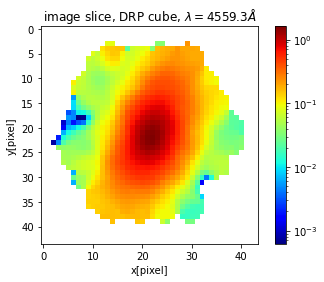

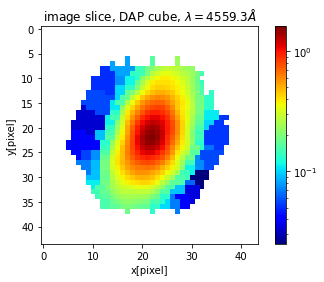

In [61]:
# First have to deredden the cubes with the REDCORR table from the DAP
corrected_cube = mycube.flux.value * cube_redcorr_
corrected_modelcube = mymodelcube.binned_flux.value * cube_redcorr_

idx = 1000
# the DRP cube is the regular unbinned datacube (logcube)
plt.imshow(corrected_cube[idx], norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( r"image slice, DRP cube, $\lambda=%.1f\AA$" %mycube.flux.wavelength[idx].value  )
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

# the DAP cube is instead patchwork binned to increase the SNR in the outskirts regions. The average of the binned
# areas are then redistributed to each contributing spaxels
plt.imshow(corrected_modelcube[idx], norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( r"image slice, DAP cube, $\lambda=%.1f\AA$" %mymodelcube.binned_flux.wavelength[idx].value  )
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

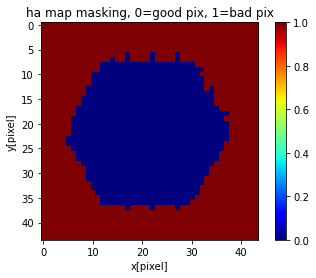

In [49]:
# masking based on H alpha map masks
nocov = ha_qual.pixmask.get_mask('NOCOV')
lowcov = ha_qual.pixmask.get_mask('LOWCOV')
donotuse = ha_qual.pixmask.get_mask('DONOTUSE')
deadfiber = ha_qual.pixmask.get_mask('DEADFIBER')
forestar = ha_qual.pixmask.get_mask('FORESTAR')
qualmask = ( (nocov) | (lowcov) | (donotuse) | (deadfiber) | (forestar) )

plt.imshow((qualmask>0), cmap='jet')
plt.colorbar()
plt.title( "ha map masking, 0=good pix, 1=bad pix"  )
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

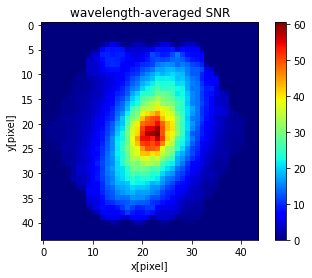

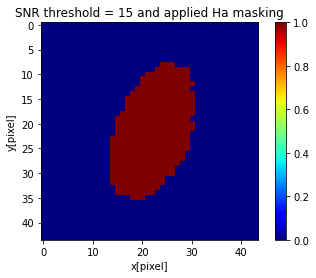

343


In [61]:
#SNR masking (SNR is unaffected by reddening, since reddening applies to both errors and flux proportionally)
mean_SNR = np.mean(mycube.flux.snr,axis=0)
plt.imshow(mean_SNR, cmap='jet')
plt.colorbar()
plt.title( r"wavelength-averaged SNR")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

summed_mask = np.sum(mycube.flux.mask,axis=0)
SNR_selection = (mean_SNR>15)&(qualmask==0)
plt.imshow(SNR_selection, cmap='jet')
plt.colorbar()
plt.title( r"SNR threshold = 15 and applied Ha masking")
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')
plt.show()

print(np.sum(SNR_selection))

# Doing it on repeat for all 15!

In [5]:
targets = pd.read_fwf('PSBs_ALMAobs_sample.txt')
IDs = targets['plateifu']

In [7]:
class galaxy:

    def __init__(self, plateifu, spectrum_SNR_threshold=10):
        #calculates summed spectrum, spaxel SNR, ha_masks, obs errors
        self.cube = marvin.tools.Cube(plateifu)
        if self.cube.mode == 'remote':
            self.cube.download()
        self.modelcube = marvin.tools.ModelCube(plateifu)
        if self.modelcube.mode == 'remote':
            self.modelcube.download()
        self.maps = marvin.tools.Maps(plateifu)
        if self.maps.mode == 'remote':
            self.maps.download()
        ha_qual = self.maps['emline_gflux_ha_6564']

        self.cube_redcorr = self.modelcube._redcorr
        cube_redcorr_ = self.cube_redcorr[:,np.newaxis,np.newaxis]
        corrected_flux = self.cube.flux.value*cube_redcorr_
        corrected_ivar = self.cube.flux.ivar/cube_redcorr_**2
        
        self.wavelength = self.cube.flux.wavelength.value
        
        self.mean_SNR = np.mean(self.cube.flux.snr,axis=0)
        nocov = ha_qual.pixmask.get_mask('NOCOV')
        lowcov = ha_qual.pixmask.get_mask('LOWCOV')
        donotuse = ha_qual.pixmask.get_mask('DONOTUSE')
        deadfiber = ha_qual.pixmask.get_mask('DEADFIBER')
        forestar = ha_qual.pixmask.get_mask('FORESTAR')
        self.qualmask = ( (nocov) | (lowcov) | (donotuse) | (deadfiber) | (forestar) )
        
        combined_mask = ((self.mean_SNR>spectrum_SNR_threshold) & (self.qualmask==0))
        # multiply by redcorr to deredden
        masked_spectrum = combined_mask*corrected_flux
        
        #self.spectrum = np.sum(masked_spectrum, axis=(1,2))*10**-17
        contribution_cube = np.zeros(np.shape(masked_spectrum))
        for i,row in enumerate(combined_mask):
            for j,maski in enumerate(row):
                if maski:
                    contribution_cube[:,i,j] = np.where(self.cube.flux.ivar[:,i,j]==0, 0, 1)
        valid_pix_spectrum_cube = contribution_cube*masked_spectrum
        valid_pix_var_cube = np.where(contribution_cube==1, 1/corrected_ivar, 0)
        #plt.imshow(np.sum(valid_pix_var_cube, axis=0), cmap='jet')
        #plt.show()
        contribution_list = np.sum(contribution_cube, axis=(1,2))
        self.spectrum = np.sum(valid_pix_spectrum_cube, axis=(1,2))*10**-17*max(contribution_list)/contribution_list
        self.errors = np.sqrt(np.sum(valid_pix_var_cube, axis=(1,2)))*10**-17*max(contribution_list)/contribution_list
        
        #dropping wavelength pixels that have summed error = 0
        zero_ind = np.where((self.errors==0)|(contribution_list==0))
        print(zero_ind)
        self.wavelength = np.delete(self.wavelength, zero_ind)
        self.spectrum = np.delete(self.spectrum, zero_ind)
        self.errors = np.delete(self.errors, zero_ind)
        print(min(self.errors),max(self.errors))

galaxies = []
for plateifu in IDs:
    galaxies.append(galaxy(plateifu, spectrum_SNR_threshold=15))

[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
7.610405198723096e-19 2.231983160135514e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
1.839450888871129e-18 4.995492131326221e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4558, 4559, 4560, 4561, 4562]),)
3.7829359528662014e-19 3.231148979692252e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
1.6666127365303664e-18 4.826470837548233e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
1.2831017033117824e-18 3.9839823314833576e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
7.913808483681123e-19 2.2517080746090542e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
8.331842106598316e-19 2.9186678114917304e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4558, 4559, 4560, 4561, 4562]),)
1.8036719578833072e-18 6.531090161207361e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
1.1685218418136085e-18 4.791066494533744e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4558, 4559, 4560, 4561, 4562]),)
1.5150628335174765e-18 5.613518060470425e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
1.9695590640591265e-18 5.935352346579186e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
1.761952870381843e-18 4.397729037012028e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4558, 4559, 4560, 4561, 4562]),)
1.5188499669580976e-18 6.985392054613605e-17


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4558, 4559, 4560, 4561, 4562]),)
2.8297235612100377e-18 1.2883624446002508e-16


[WARNING]: mismatch between file version=DR16 and object release=DR15. Setting object release to DR16 (MarvinUserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


(array([4562]),)
3.647807190254848e-18 1.0187574553051314e-16


7.610405198723096e-19 2.231983160135514e-17 (4562,)
1.839450888871129e-18 4.995492131326221e-17 (4562,)
3.7829359528662014e-19 3.231148979692252e-17 (4558,)
1.6666127365303664e-18 4.826470837548233e-17 (4562,)
1.2831017033117824e-18 3.9839823314833576e-17 (4562,)
7.913808483681123e-19 2.2517080746090542e-17 (4562,)
8.331842106598316e-19 2.9186678114917304e-17 (4562,)
1.8036719578833072e-18 6.531090161207361e-17 (4558,)
1.1685218418136085e-18 4.791066494533744e-17 (4562,)
1.5150628335174765e-18 5.613518060470425e-17 (4558,)
1.9695590640591265e-18 5.935352346579186e-17 (4562,)
1.761952870381843e-18 4.397729037012028e-17 (4562,)
1.5188499669580976e-18 6.985392054613605e-17 (4558,)
2.8297235612100377e-18 1.2883624446002508e-16 (4558,)
3.647807190254848e-18 1.0187574553051314e-16 (4562,)


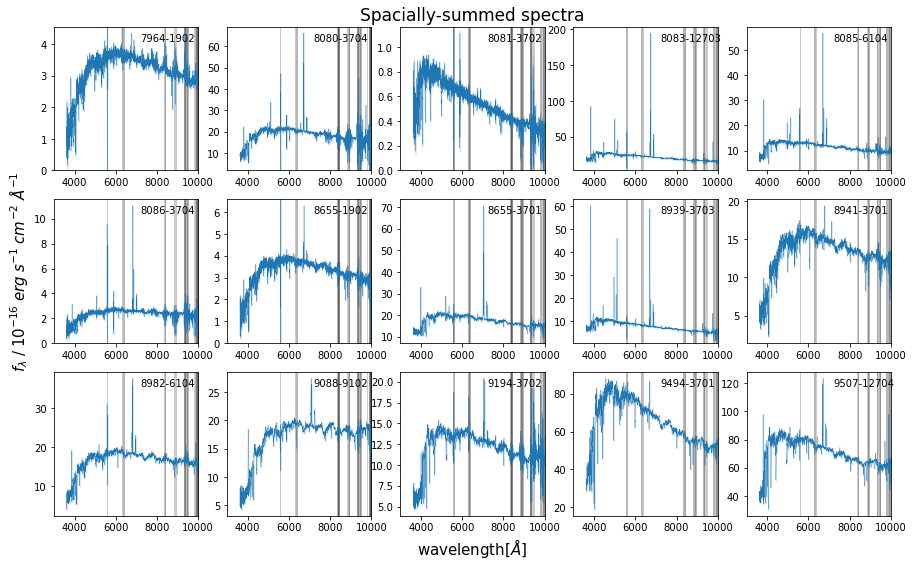

In [8]:
# spectrum
fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    #axi.annotate(str(i),[0.5,0.5])
    spec_mask, mask_lims = mask_sky(gal.wavelength)
    spec_masked = np.delete(gal.spectrum, spec_mask)
    ylims = np.array([min(spec_masked[np.delete(gal.wavelength, spec_mask)<10000]),
                      max(spec_masked[np.delete(gal.wavelength, spec_mask)<10000])])*10**16
    ylims = [ylims[0]-np.diff(ylims)*0.05, ylims[1]+np.diff(ylims)*0.05]
    axi.plot(gal.wavelength, gal.spectrum*10**16, lw=0.3)
    print(min(gal.errors), max(gal.errors), np.shape(gal.errors))
    axi.fill_between(gal.wavelength, gal.spectrum*10**16-gal.errors*10**16, gal.spectrum*10**16+gal.errors*10**16,
                    color='steelblue', alpha=0.2)
    for mask_lim_i in mask_lims:
        axi.fill_between(mask_lim_i, ylims[1], ylims[0], color='black', alpha=0.2)
    axi.set_xlim(3000,10000)
    axi.set_ylim([max([ylims[0],0]),ylims[1]])
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes)
    
ax[2,2].set_xlabel('wavelength[$\AA$]', fontsize=15)
ax[1,0].set_ylabel('$f_\lambda \;/\; 10^{-16} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
ax[0,2].set_title('Spacially-summed spectra', fontsize=17)
plt.show()

In [79]:
for i,gal in enumerate(galaxies):
    save_df = pd.DataFrame({'observed-wave[AA]':gal.wavelength.byteswap().newbyteorder(),
                            'flux[10^-16 erg/s/cm^2/AA]':gal.spectrum.byteswap().newbyteorder()*10**16, 
                            'noise[10^-16 erg/s/cm^2/AA]':gal.errors.byteswap().newbyteorder()*10**16})
    save_name = 'manga_data/Spectrum_'+IDs[i]+'_SNR15_dereddened.csv'
    print(save_name)
    save_df[save_df['observed-wave[AA]'].between(3000,9500)].to_csv(save_name, index=False)

manga_data/Spectrum_9507-12704_SNR15_dereddened.csv
manga_data/Spectrum_8655-1902_SNR15_dereddened.csv
manga_data/Spectrum_9494-3701_SNR15_dereddened.csv
manga_data/Spectrum_8941-3701_SNR15_dereddened.csv
manga_data/Spectrum_9194-3702_SNR15_dereddened.csv
manga_data/Spectrum_8939-3703_SNR15_dereddened.csv
manga_data/Spectrum_8080-3704_SNR15_dereddened.csv
manga_data/Spectrum_8086-3704_SNR15_dereddened.csv
manga_data/Spectrum_9088-9102_SNR15_dereddened.csv
manga_data/Spectrum_7964-1902_SNR15_dereddened.csv
manga_data/Spectrum_8081-3702_SNR15_dereddened.csv
manga_data/Spectrum_8083-12703_SNR15_dereddened.csv
manga_data/Spectrum_8085-6104_SNR15_dereddened.csv
manga_data/Spectrum_8982-6104_SNR15_dereddened.csv
manga_data/Spectrum_8655-3701_SNR15_dereddened.csv


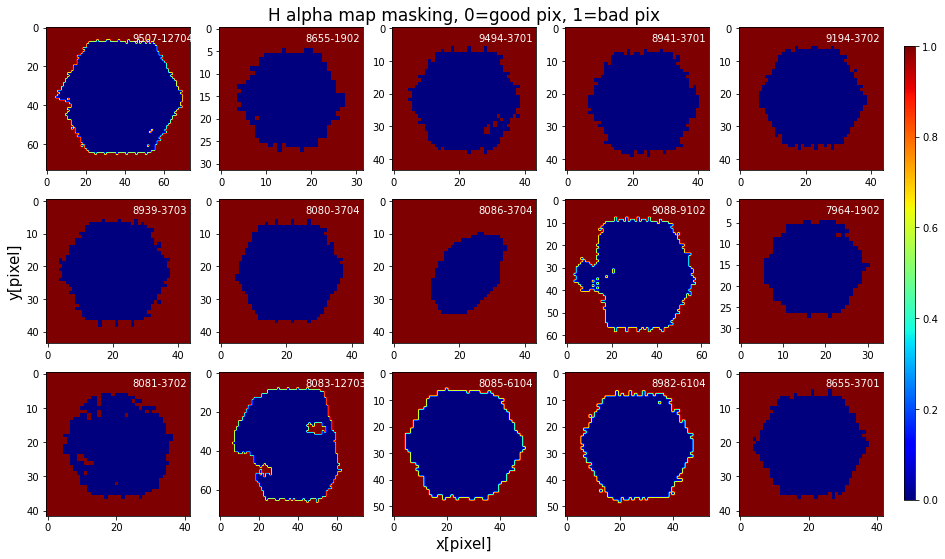

In [76]:
# Halpha map masking
fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    #axi.annotate(str(i),[0.5,0.5])
    im = axi.imshow((gal.qualmask>0), cmap='jet')
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax[2,2].set_xlabel('x[pixel]', fontsize=15)
ax[1,0].set_ylabel('y[pixel]', fontsize=15)
ax[0,2].set_title('H alpha map masking, 0=good pix, 1=bad pix', fontsize=17)
plt.show()


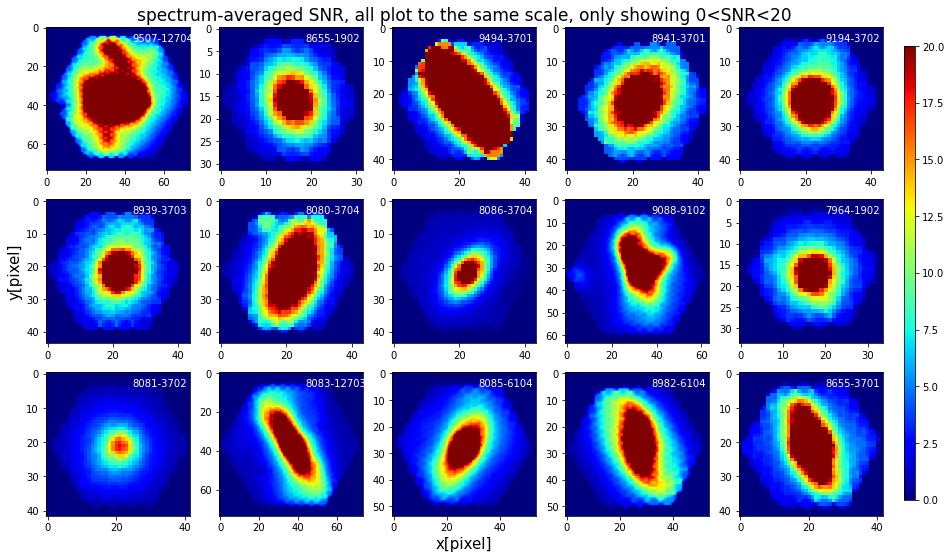

In [248]:
# SNR plots
max_snrs = []
for gal in galaxies:
    max_snrs.append(np.max(gal.mean_SNR))
max_snr = max(max_snrs)

fig, ax = plt.subplots(3,5, figsize=[15,9])
for i,gal in enumerate(galaxies):
    axi = ax[i // 5, i % 5]
    #axi.annotate(str(i),[0.5,0.5])
    im = axi.imshow(gal.mean_SNR, cmap='jet', vmin=0, vmax=20)
    axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax[2,2].set_xlabel('x[pixel]', fontsize=15)
ax[1,0].set_ylabel('y[pixel]', fontsize=15)
ax[0,2].set_title('spectrum-averaged SNR, all plot to the same scale, only showing 0<SNR<20', fontsize=17)
plt.show()


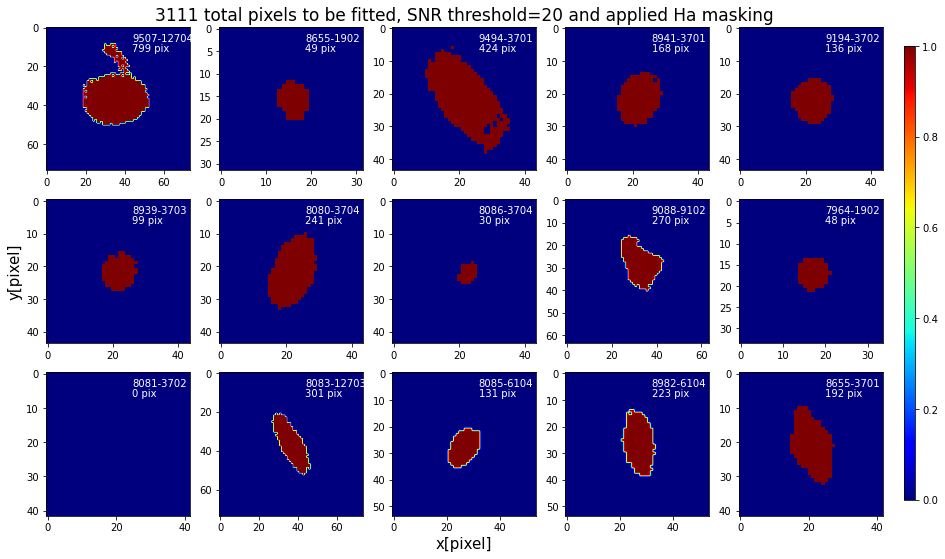

assuming 2 hours per fit per core and using 120 cores at once, total time needed = 51.85 hours


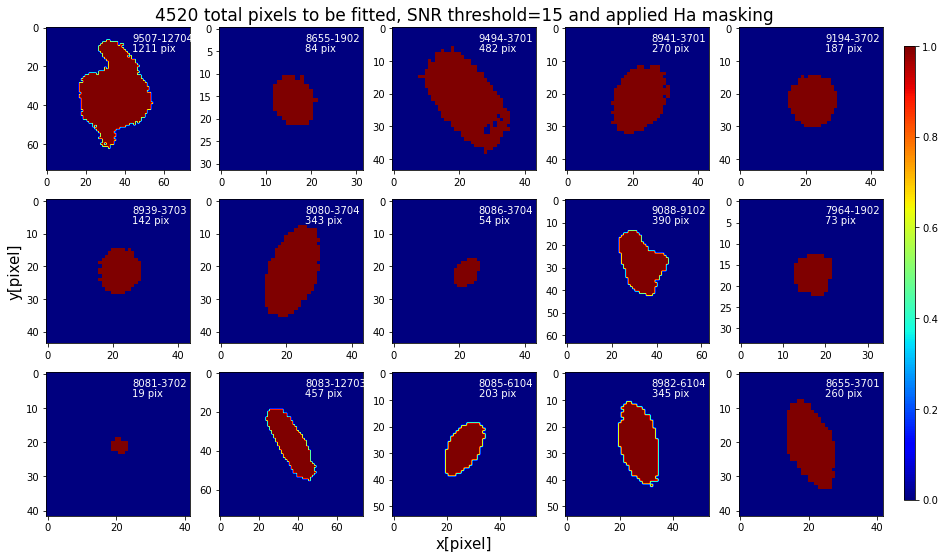

assuming 2 hours per fit per core and using 120 cores at once, total time needed = 75.33333333333333 hours


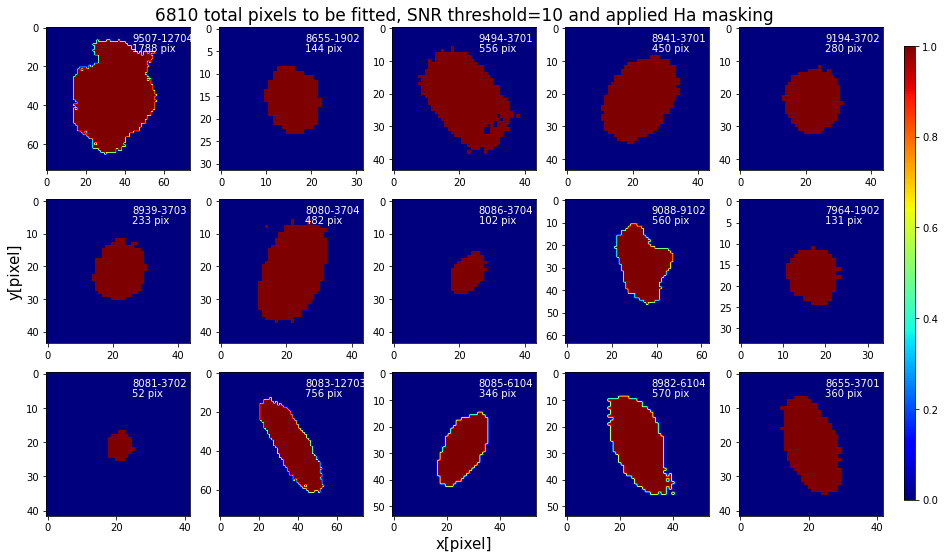

assuming 2 hours per fit per core and using 120 cores at once, total time needed = 113.5 hours


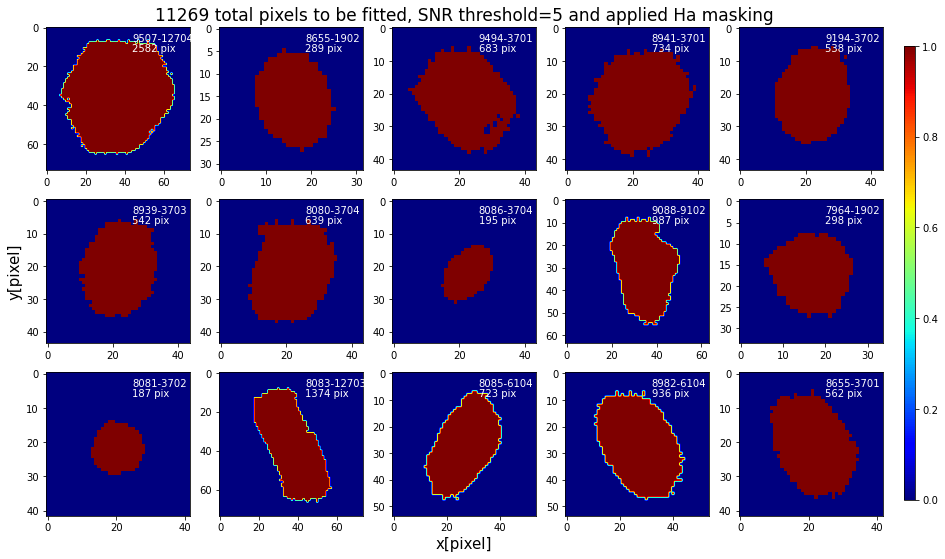

assuming 2 hours per fit per core and using 120 cores at once, total time needed = 187.81666666666666 hours


In [253]:
# SNR>20,15,10,5 thresholds
for SNR_threshold in [20,15,10,5]:
    total_good_pix = 0
    fig, ax = plt.subplots(3,5, figsize=[15,9])
    for i,gal in enumerate(galaxies):
        axi = ax[i // 5, i % 5]
        #axi.annotate(str(i),[0.5,0.5])
        SNR_selection = (gal.mean_SNR>SNR_threshold)&(gal.qualmask==0)
        im = axi.imshow(SNR_selection, cmap='jet')
        axi.text(0.6,0.9, IDs[i], transform=axi.transAxes,color='white')
        axi.text(0.6,0.83, f'{np.sum(SNR_selection)} pix', transform=axi.transAxes,color='white')
        total_good_pix += np.sum(SNR_selection)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    ax[2,2].set_xlabel('x[pixel]', fontsize=15)
    ax[1,0].set_ylabel('y[pixel]', fontsize=15)
    ax[0,2].set_title(f'{total_good_pix} total pixels to be fitted, SNR threshold={SNR_threshold} and applied Ha masking', fontsize=17)
    plt.show()
    print(f'assuming 2 hours per fit per core and using 120 cores at once, total time needed = {total_good_pix*2/120} hours')



In [7]:
from scipy.stats import norm
x = np.linspace(-5,5,10000)
y = norm.pdf(x)
np.trapz(y=y[x>0.6], x=x[x>0.6])*2

0.548132509389228

In [21]:
x = np.random.randn(10000)
print(x.var(),np.mean(x))
y = x**4
print(y.var(),np.mean(y),np.mean(y)**2*16)

0.9930667603489896 -0.021223814368001775
103.65610865146932 3.005035936280742 144.48385565341883


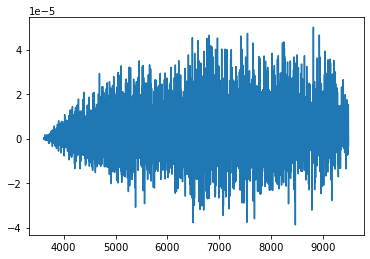

In [82]:
regular_spectrum = np.loadtxt('manga_data/Spectrum_7964-1902_SNR15.csv', delimiter=',', skiprows=1)
dereddened_spectrum = np.loadtxt('manga_data/Spectrum_7964-1902_SNR15_dereddened.csv', delimiter=',', skiprows=1)

SNR_A = regular_spectrum[:,1]/regular_spectrum[:,2]
SNR_B = dereddened_spectrum[:,1]/dereddened_spectrum[:,2]

plt.plot(regular_spectrum[:,0], SNR_A-SNR_B)